In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt
from xgboost import plot_importance

In [2]:
data = pd.read_csv('/Users/haixiangliu/Documents/水质数据及代码模型/water_clean_data.csv')

In [3]:
data.columns=['datetime','water_level','do','miss','input_wind_throughput','input_wind_openness','ts','input_water_cod','output_water_cod','input_water_ammonia','output_water_ammonia','input_water_ph','output_water_phosphorus','input_water_ss','output_water_ss']

In [4]:
datetime_array=[]
for value in data['datetime']:
    datetime_array.append(value)
data[data<0]=np.nan
data['datetime']=pd.DataFrame(datetime_array)
data = data.fillna(0.0)

In [5]:
index_array=[]
for d in data['output_water_cod']:
    if d>=50:
        index_array.append(1)  
    else:
        index_array.append(0)
data['label']=pd.DataFrame(index_array)

In [6]:
#提取年、月、周/年、小时形成新列，并修改数据类型
#data['year']=pd.to_datetime(data['datetime']).dt.year
#data['month']=pd.to_datetime(data['datetime']).dt.month
#data['weekofyear']=pd.to_datetime(data['datetime']).dt.weekofyear
#data['hour']=pd.to_datetime(data['datetime']).dt.hour
#data[['year','month','weekofyear','hour']] = data[['year','month','weekofyear','hour']].astype('float')

In [7]:
#抽样进行训练，预测
data1=data[data['label']==0]
data2=data[data['label']==1]
#抽取label=0的数据的20%
sample_data1 = data1.sample(frac=0.02)
#数据中label=1的所有数据
sampled_data=data2.append(sample_data1)

In [8]:
y = sampled_data['label']
x = sampled_data.drop(['output_water_cod','datetime','label'],axis=1)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.1,random_state=0)

In [10]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

### XGBoost_Cross_validation

In [21]:
params= {'max_depth':2,'eta':1,'silent':1,'objective':'binary:logistic'}
num_round=2
xgb.cv(params,dtrain,num_round,nfold=5,metrics={'error'},seed=0,
          callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

[0]	train-error:0.084316+0.00701375	test-error:0.0851116+0.0227327
[1]	train-error:0.0813802+0.00955156	test-error:0.0997102+0.016407


,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.084316,0.007014,0.085112,0.022733
1,0.081380,0.009552,0.099710,0.016407


In [18]:
res = xgb.cv(params, dtrain, num_boost_round=10, nfold=5,
             metrics={'error'}, seed=0,
             callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                        xgb.callback.early_stop(3)])
print(res)
print('running cross validation, with preprocessing function')

[0]	train-error:0.084316	test-error:0.0851116
Multiple eval metrics have been passed: 'test-error' will be used for early stopping.

Will train until test-error hasn't improved in 3 rounds.
[1]	train-error:0.0813802	test-error:0.0997102
[2]	train-error:0.0769818	test-error:0.0982608
[3]	train-error:0.072584	test-error:0.096801
Stopping. Best iteration:
[0]	train-error:0.084316+0.00701375	test-error:0.0851116+0.0227327

   train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.084316         0.007014         0.085112        0.022733
running cross validation, with preprocessing function


In [19]:
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

# 对每一个折都要进行交叉验证,dtrain, dtest, param将被传入fpreproc,然后fpreproc的返回值将用于生成该折叠的结果
xgb.cv(params, dtrain, num_round, nfold=5,
       metrics={'auc'}, seed=0, fpreproc=fpreproc)

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.792625,0.012870,0.698916,0.023580
1,0.850997,0.008371,0.769880,0.025194


### Predict_first_ntree

In [22]:
params = {'max_depth':2,'eta':1,'silent':1,'objective':'binary:logistic'}
watchlist = [(dtrain,'train'),(dtest,'eval')]
num_round=3
bst = xgb.train(params,dtrain,num_round,watchlist)

[0]	train-error:0.085044	eval-error:0.105263
[1]	train-error:0.083578	eval-error:0.105263
[2]	train-error:0.083578	eval-error:0.105263


In [23]:
#从第n棵树开始测试预测
label= dtest.get_label()
ypred1 = bst.predict(dtest,ntree_limit=1)
ypred2 = bst.predict(dtest)
print('error of ypred1=%f' % (np.sum((ypred1 > 0.5) != label) / float(len(label))))
print('error of ypred2=%f' % (np.sum((ypred2 > 0.5) != label) / float(len(label))))

error of ypred1=0.105263
error of ypred2=0.105263


### 预测叶指数

In [11]:
params = {'max_depth':2,'eta':1,'silent':1,'objective':'binary:logistic'}
watchlist =[(dtest,'eval'),(dtrain,'train')] 
num_round=3
bst = xgb.train(params,dtrain,num_round,watchlist)

[0]	eval-error:0.105263	train-error:0.085044
[1]	eval-error:0.105263	train-error:0.083578
[2]	eval-error:0.105263	train-error:0.083578


In [14]:

leafindex = bst.predict(dtest,ntree_limit=2,pred_leaf=True)
print(leafindex.shape)
print(leafindex)

(76, 2)
[[4 6]
 [4 3]
 [4 6]
 [4 6]
 [4 6]
 [4 3]
 [4 6]
 [4 4]
 [4 6]
 [4 3]
 [4 6]
 [4 6]
 [4 3]
 [6 4]
 [4 6]
 [4 3]
 [4 3]
 [4 3]
 [4 4]
 [4 3]
 [4 6]
 [4 6]
 [4 6]
 [4 3]
 [4 6]
 [4 3]
 [4 6]
 [4 6]
 [4 6]
 [4 3]
 [4 6]
 [4 6]
 [4 6]
 [4 6]
 [4 3]
 [4 3]
 [4 4]
 [4 6]
 [4 4]
 [4 3]
 [4 6]
 [4 3]
 [4 3]
 [4 6]
 [4 6]
 [4 3]
 [4 3]
 [3 3]
 [4 4]
 [4 6]
 [4 6]
 [4 3]
 [4 6]
 [4 6]
 [3 4]
 [4 3]
 [4 6]
 [4 6]
 [4 3]
 [4 6]
 [4 6]
 [4 4]
 [4 6]
 [4 3]
 [4 6]
 [4 3]
 [4 4]
 [4 6]
 [4 6]
 [4 3]
 [4 3]
 [4 6]
 [4 6]
 [4 6]
 [3 3]
 [4 6]]


In [13]:
leafindex = bst.predict(dtest, pred_leaf=True)
print(leafindex.shape)

(76, 3)


### 用XGBClassifier模型进行预测

In [24]:
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

In [25]:
num_round=100
model = XGBClassifier(learning_rate = 0.1,
                      n_estimators=1000,   #树的个数
                      max_depth=6,           #树的深度
                      min_child_weight=1,  #叶子节点最小权重
                      gamma=0.,              #惩罚项中叶子结点个数前的参数
                      subsample=0.8,       #随机选择80%样本建立决策树
                      colsample_btree=0.8,#随机选择80%特征建立决策树
                      objective = 'multi:softmax',#指定损失函数
                      num_class=2,
                      scale_pos_weight=1,  #解决样本个数不平衡问题
                      random_state=27,     #随机数
                     )

In [26]:
model.fit(X_train,y_train,eval_set =[(X_test,y_test)],eval_metric='mlogloss',early_stopping_rounds=10,verbose=True)

[0]	validation_0-mlogloss:0.625208
Will train until validation_0-mlogloss hasn't improved in 10 rounds.
[1]	validation_0-mlogloss:0.567624
[2]	validation_0-mlogloss:0.521388
[3]	validation_0-mlogloss:0.484331
[4]	validation_0-mlogloss:0.451096
[5]	validation_0-mlogloss:0.426219
[6]	validation_0-mlogloss:0.404829
[7]	validation_0-mlogloss:0.385539
[8]	validation_0-mlogloss:0.369283
[9]	validation_0-mlogloss:0.354838
[10]	validation_0-mlogloss:0.342745
[11]	validation_0-mlogloss:0.329837
[12]	validation_0-mlogloss:0.318981
[13]	validation_0-mlogloss:0.308072
[14]	validation_0-mlogloss:0.29945
[15]	validation_0-mlogloss:0.290763
[16]	validation_0-mlogloss:0.28548
[17]	validation_0-mlogloss:0.282849
[18]	validation_0-mlogloss:0.281738
[19]	validation_0-mlogloss:0.275487
[20]	validation_0-mlogloss:0.269904
[21]	validation_0-mlogloss:0.267125
[22]	validation_0-mlogloss:0.263785
[23]	validation_0-mlogloss:0.262723
[24]	validation_0-mlogloss:0.25969
[25]	validation_0-mlogloss:0.257069
[26]	val

XGBClassifier(base_score=0.5, booster='gbtree', colsample_btree=0.8,
       colsample_bylevel=1, colsample_bytree=1, gamma=0.0,
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, num_class=2, objective='multi:softmax',
       random_state=27, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

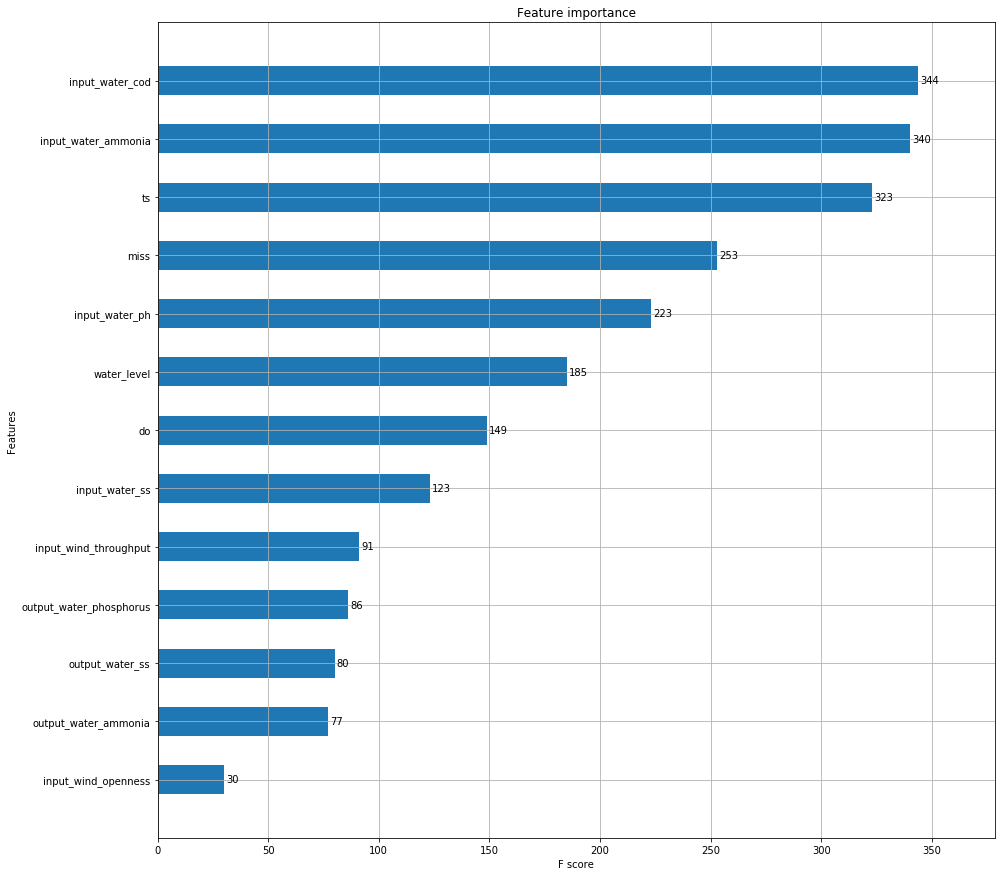

In [27]:
#绘制feature的重要性
fig,ax = plt.subplots(figsize=(15,15))
plot_importance(model,height=0.5,ax=ax,max_num_features=64)

In [28]:
pred = model.predict(X_test)

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [29]:
pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [30]:
#该预测的精度
from sklearn.metrics import precision_score
print('Precision_Score:'+str(precision_score(y_test,pred,average='macro')))

#模型评估
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test,pred)
print('accuracy:%.2f%%' %(accuracy*100.0))

Precision_Score:0.7083333333333333
accuracy:89.47%


### Pearson相关性分析

In [176]:
#用Pearson相关，求feature_importance
from scipy.stats import pearsonr
columns = X_train.columns

feature_importance=[(column,pearsonr(X_train[column],y_train)[0]) for column in columns]
feature_importance.sort(key=lambda x:x[1])

feature_importance

[('ts', -0.2883084452776026),
 ('input_water_ss', -0.12340412392641328),
 ('input_water_ammonia', -0.1207493104150717),
 ('miss', -0.10809656924228259),
 ('input_wind_openness', -0.07216276135557602),
 ('input_wind_throughput', -0.049290039114645134),
 ('water_level', -0.026388351472986234),
 ('input_water_cod', -0.025408401245447285),
 ('output_water_ss', 0.03179729986241738),
 ('do', 0.09183393910192708),
 ('input_water_ph', 0.1380970352349247),
 ('output_water_ammonia', 0.3778876871384895),
 ('output_water_phosphorus', 0.42997343159307655),
 ('label', 1.0)]

通过Pearson相关得到的feature和label的线性关系并不明显

### 使用线性模型L1做特征选择 

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
lr=LogisticRegression(penalty='l1',random_state=0).fit(X_train,y_train)
pred=lr.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test,pred))
 
feature_importance=[(i[0],i[1]) for i in zip(columns,lr.coef_[0])]
feature_importance.sort(key=lambda x:np.abs(x[1]))
#特征系数
feature_importance

0.7959558823529411


[('ts', -4.024636665429571e-11),
 ('miss', -3.972560926063287e-05),
 ('input_wind_throughput', -4.102525863031357e-05),
 ('input_water_cod', -0.00039818340669135527),
 ('input_water_ss', -0.0015074692004011974),
 ('input_wind_openness', 0.005366042201123543),
 ('input_water_ph', 0.017618396090336812),
 ('output_water_ss', -0.03757238793274894),
 ('input_water_ammonia', -0.039366079931155096),
 ('output_water_ammonia', 0.09127269804466788),
 ('do', 0.10092172540272301),
 ('water_level', -0.13943815332982443),
 ('output_water_phosphorus', 0.8457689095376573)]

### 使用线性模型L2进行特征选择

In [102]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(x, y, test_size=0.1, random_state=0)
lr=LogisticRegression(penalty='l2',random_state=0).fit(X_train2,y_train2)
pred=lr.predict_proba(X_test2)[:,1]
print(roc_auc_score(y_test2,pred))
 
feature_importance=[(i[0],i[1]) for i in zip(columns,lr.coef_[0])]
feature_importance.sort(key=lambda x:np.abs(x[1]))
feature_importance

0.7628676470588235


[('do', -3.2476148692454115e-19),
 ('output_water_phosphorus', 4.9317584691110855e-19),
 ('output_water_ss', -5.226903562539908e-18),
 ('water_level', -5.658971879091991e-18),
 ('input_water_ph', -6.924287011910742e-18),
 ('output_water_ammonia', 9.931940696695707e-18),
 ('input_water_ammonia', -4.2657723134179207e-17),
 ('input_wind_openness', -5.1575881173874646e-17),
 ('input_water_cod', -3.030316530688926e-16),
 ('input_water_ss', -8.156270777870916e-16),
 ('input_wind_throughput', -1.9735554170796883e-15),
 ('miss', -4.77459009369226e-15),
 ('ts', -1.5694231525070371e-09)]

### 使用平均精确率减少做特征选择

In [172]:
from sklearn.metrics import r2_score
from collections import defaultdict

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)
rf=RandomForestClassifier(n_estimators=300,max_depth=7,min_samples_split=10,min_samples_leaf=10,n_jobs=7,random_state=0)
scores = defaultdict(list)


In [173]:
from sklearn.cross_validation import ShuffleSplit
for train_idx, test_idx in ShuffleSplit(len(X_train), 3, 0.3):
    x_train, X_test = X_train.values[train_idx], X_train.values[test_idx]
    Y_train, Y_test = y_train.values[train_idx], y_train.values[test_idx]
    r = rf.fit(x_train, Y_train)
    acc = r2_score(Y_test, rf.predict_proba(X_test)[:,1])
    for i in range(x_train.shape[1]):
        X_t = X_test.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = r2_score(Y_test, rf.predict_proba(X_t)[:,1])
        scores[columns[i]].append((acc - shuff_acc) / acc)
feature_impotance=sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()])
feature_impotance

[(-0.0815, 'input_wind_throughput'),
 (-0.08, 'miss'),
 (-0.0301, 'output_water_ss'),
 (-0.0207, 'do'),
 (-0.0058, 'input_wind_openness'),
 (0.0123, 'water_level'),
 (0.0539, 'input_water_ss'),
 (0.085, 'input_water_ph'),
 (0.0899, 'input_water_ammonia'),
 (0.2549, 'output_water_ammonia'),
 (0.3135, 'ts'),
 (0.3167, 'output_water_phosphorus'),
 (0.6436, 'input_water_cod')]

### 顶级特征选择算法 ???

In [174]:
#稳定性选择 
from sklearn.linear_model import  RandomizedLasso

Y=sampled_data['label']
X=sampled_data.drop(['datetime','output_water_cod'],axis=1)
names=data.columns

rlasso = RandomizedLasso()
rlasso.fit(X,Y)

In [167]:
print("Features sorted by their score:")
feature_importance=sorted(zip(map(lambda x: round(x, 4), rlasso.scores_),names))
feature_importance

Features sorted by their score:


[(0.0, 'datetime'),
 (0.0, 'do'),
 (0.0, 'input_water_ammonia'),
 (0.0, 'input_water_cod'),
 (0.0, 'input_water_ph'),
 (0.0, 'input_wind_openness'),
 (0.0, 'input_wind_throughput'),
 (0.0, 'miss'),
 (0.0, 'output_water_cod'),
 (0.0, 'output_water_phosphorus'),
 (0.0, 'ts'),
 (0.0, 'water_level'),
 (0.005, 'output_water_ammonia'),
 (1.0, 'input_water_ss')]

In [175]:
#递归特征消除 Recursive feature elimination (RFE)
from sklearn.feature_selection import RFE
 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
# use linear regression as the model
rf = RandomForestClassifier()
# rank all features, i.e continue the elimination until the last one
rfe = RFE(rf, n_features_to_select=1,verbose=1)
rfe.fit(X_train, y_train)

print("Features sorted by their rank:")
feature_importance=(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), columns),reverse=True))
feature_importance


Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Features sorted by their rank:


[(14, 'output_water_ss'),
 (13, 'input_wind_throughput'),
 (12, 'input_wind_openness'),
 (11, 'input_water_ss'),
 (10, 'water_level'),
 (9, 'input_water_ammonia'),
 (8, 'miss'),
 (7, 'do'),
 (6, 'input_water_cod'),
 (5, 'ts'),
 (4, 'output_water_ammonia'),
 (3, 'input_water_ph'),
 (2, 'output_water_phosphorus')]